In [74]:
import sys

import meta_dataloader.TCGA

import models.mlp, models.gcn
import numpy as np
import data.gene_graphs
import collections
import sklearn.metrics
import sklearn.model_selection
import random
from collections import OrderedDict
import pandas as pd
from torch.optim import Optimizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import csv
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
tasks = meta_dataloader.TCGA.TCGAMeta(download=True, 
                                      min_samples_per_class=10)

Torrent name: HiSeqV2.gz, Size: 513.04MB


In [65]:
print(len(tasks.task_ids))

174


In [66]:
taskids = []
for taskid in sorted(tasks.task_ids):
    taskids.append(taskid)

In [77]:
path = '/Users/mandanasamiei/PycharmProjects/TCGA_Benchmark'

In [97]:
def all_visualization(Maj_means,LR_means, Mlp_means, Maj_std, LR_std, Mlp_std, tasks):
    
    x = np.arange(len(tasks))
    new_x = [1.5*i for i in x]
    fig, ax = plt.subplots(figsize=(100, 10), dpi=150)
    width = 0.4
    colors = ['#332288', '#AA4499', '#44AA99']
    ax.bar([p - width for p in new_x],
            Maj_means,
            width,
            alpha=0.7,
            color='#332288',
            label='Majority')
    ax.bar(new_x,
            LR_means,
            width,
            alpha=0.7,
            color='#AA4499',
            label='LR')
    ax.bar([p + width for p in new_x],
            Mlp_means,
            width,
            alpha=0.7,
            color='#44AA99',
            label='MLP')
    
    ax.set_ylabel('Accuracy')
    ax.set_title('Baseline Performances over clinical tasks')
    ax.set_xticks([p  for p in new_x])
    ax.set_xticklabels(tasks, rotation=45, ha="right")
    fig.tight_layout()

    plt.legend(['Majority', 'LR', 'MLP'], loc='upper left')
    plt.grid()
    
    # Error bars
    x_e, y_e, e = [], [], []
    for i in new_x:
        x_e.append([i-width, i, i+width])

    for i, task in enumerate(tasks):
        y_e.append([Maj_means[i], LR_means[i], Mlp_means[i]])

    for i, task in enumerate(tasks):
        e.append([Maj_std[i], LR_std[i], Mlp_std[i]])

    flatten_x = [item for sublist in x_e for item in sublist]
    flatten_y = [item for sublist in y_e for item in sublist]
    flatten_e = [item for sublist in e for item in sublist]


    plt.xlim(min(new_x) - 3 * width, max(new_x) + width * 3)
    plt.ylim(0, 100)

    plt.errorbar(flatten_x, flatten_y, flatten_e, linestyle='None', marker='o', color='r', alpha=0.5)
    plt.savefig(path + '/results_all_model.png')
    plt.show()

In [68]:
maj_means, maj_stds = [], []
Maj_res= []
csv_file = 'Majority_result_10seeds.csv'
df = pd.read_csv(csv_file)
for i in df['mean']:
    maj_means.append(i)
    
for i in df['std']:
    maj_stds.append(i)

Maj_res.append(maj_means)
Maj_res.append(maj_stds)
print(Maj_res)

[[38.0, 38.0, 33.0, 98.0, 49.0, 45.0, 55.00000000000001, 83.0, 75.0, 75.0, 76.0, 57.99999999999999, 77.0, 62.0, 55.00000000000001, 84.0, 65.0, 75.0, 61.0, 63.0, 59.0, 55.00000000000001, 60.0, 52.0, 63.0, 52.0, 61.0, 97.0, 81.0, 30.0, 41.0, 43.0, 38.0, 32.0, 38.0, 35.0, 31.0, 56.99999999999999, 28.000000000000004, 60.0, 52.0, 73.0, 67.0, 61.0, 73.0, 77.0, 95.0, 95.0, 79.0, 94.0, 94.0, 91.0, 87.0, 55.00000000000001, 75.0, 66.0, 66.0, 71.0, 62.0, 62.0, 96.0, 96.0, 95.0, 73.0, 99.0, 54.0, 54.0, 84.0, 65.0, 56.99999999999999, 73.0, 73.0, 54.0, 55.00000000000001, 66.0, 54.0, 60.0, 74.0, 55.00000000000001, 55.00000000000001, 55.00000000000001, 62.0, 65.0, 73.0, 49.0, 38.0, 82.0, 97.0, 62.0, 69.0, 69.0, 55.00000000000001, 64.0, 69.0, 75.0, 75.0, 67.0, 85.0, 62.0, 55.00000000000001, 57.99999999999999, 63.0, 51.0, 59.0, 60.0, 65.0, 69.0, 89.0, 85.0, 80.0, 60.0, 57.99999999999999, 65.0, 95.0, 96.0, 76.0, 76.0, 82.0, 77.0, 77.0, 74.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [69]:
lr_means, lr_stds = [], []
LR_res= []
csv_file = 'LogisticRegression_result_10seeds.csv'
df = pd.read_csv(csv_file)
for i in df['mean']:
    lr_means.append(i)
    
for i in df['std']:
    lr_stds.append(i)

LR_res.append(lr_means)
LR_res.append(lr_stds)
print(LR_res)

[[60.63636363636363, 60.63636363636363, 62.36363636363637, 98.0, 40.90909090909091, 69.0, 55.45454545454545, 75.45454545454545, 68.63636363636364, 71.36363636363636, 65.36363636363636, 54.54545454545455, 66.18181818181819, 73.18181818181819, 57.09090909090909, 84.27272727272727, 52.72727272727273, 70.81818181818181, 57.81818181818182, 55.54545454545455, 58.18181818181818, 55.72727272727273, 54.45454545454545, 56.0, 54.81818181818182, 59.18181818181818, 56.90909090909091, 95.9090909090909, 78.54545454545455, 47.63636363636363, 62.36363636363637, 46.27272727272727, 52.63636363636363, 23.72727272727273, 51.90909090909091, 59.18181818181818, 33.81818181818182, 48.72727272727273, 26.818181818181817, 68.27272727272727, 52.54545454545455, 62.27272727272727, 65.36363636363636, 51.54545454545455, 64.18181818181819, 71.45454545454545, 89.9090909090909, 89.9090909090909, 75.63636363636364, 92.9090909090909, 92.9090909090909, 88.27272727272727, 81.81818181818181, 45.54545454545455, 68.818181818181

In [70]:
MLP_res = {}

In [71]:
MLP_res = {('Expression_Subtype', 'LUAD'): {'mean': 68.2, 'std': 1.5999999999999999}, ('Expression_Subtype', 'LUNG'): {'mean': 68.2, 'std': 1.5999999999999999}, ('GeneExp_Subtype', 'GBM'): {'mean': 73.3, 'std': 1.4177446878757824}, ('Metastasis_nature2012', 'BRCA'): {'mean': 98.0, 'std': 0.0}, ('Node_nature2012', 'BRCA'): {'mean': 47.5, 'std': 2.4596747752497685}, ('PAM50Call_RNAseq', 'BRCA'): {'mean': 81.0, 'std': 2.04939015319192}, ('_EVENT', 'BLCA'): {'mean': 58.6, 'std': 1.5620499351813317}, ('_EVENT', 'BRCA'): {'mean': 82.9, 'std': 0.9433981132056604}, ('_EVENT', 'CESC'): {'mean': 68.6, 'std': 1.1135528725660042}, ('_EVENT', 'COAD'): {'mean': 75.7, 'std': 0.6403124237432849}, ('_EVENT', 'COADREAD'): {'mean': 72.4, 'std': 0.9165151389911681}, ('_EVENT', 'ESCA'): {'mean': 52.4, 'std': 0.9165151389911679}, ('_EVENT', 'GBM'): {'mean': 73.9, 'std': 0.7000000000000001}, ('_EVENT', 'GBMLGG'): {'mean': 74.1, 'std': 0.30000000000000004}, ('_EVENT', 'HNSC'): {'mean': 60.1, 'std': 1.3000000000000012}, ('_EVENT', 'KIRP'): {'mean': 85.9, 'std': 0.30000000000000004}, ('_EVENT', 'LAML'): {'mean': 60.2, 'std': 1.6613247725836133}, ('_EVENT', 'LGG'): {'mean': 75.9, 'std': 0.30000000000000004}, ('_EVENT', 'LIHC'): {'mean': 62.4, 'std': 1.4966629547095764}, ('_EVENT', 'LUAD'): {'mean': 57.5, 'std': 2.109502310972899}, ('_EVENT', 'LUNG'): {'mean': 62.0, 'std': 1.2649110640673518}, ('_EVENT', 'LUSC'): {'mean': 58.1, 'std': 1.0440306508910577}, ('_EVENT', 'OV'): {'mean': 58.2, 'std': 0.6000000000000029}, ('_EVENT', 'PAAD'): {'mean': 58.0, 'std': 2.323790007724449}, ('_EVENT', 'SARC'): {'mean': 56.5, 'std': 1.68819430161341}, ('_EVENT', 'SKCM'): {'mean': 61.4, 'std': 0.9165151389911681}, ('_EVENT', 'STAD'): {'mean': 57.9, 'std': 1.8681541692269397}, ('_EVENT', 'THCA'): {'mean': 97.0, 'std': 0.0}, ('_EVENT', 'UCEC'): {'mean': 79.9, 'std': 0.3}, ('_PANCAN_DNAMethyl_BRCA', 'BRCA'): {'mean': 52.3, 'std': 1.9519221295943157}, ('_PANCAN_DNAMethyl_HNSC', 'HNSC'): {'mean': 75.0, 'std': 0.8944271909999159}, ('_PANCAN_DNAMethyl_LUAD', 'LUAD'): {'mean': 52.4, 'std': 1.9078784028338933}, ('_PANCAN_DNAMethyl_LUSC', 'LUSC'): {'mean': 61.0, 'std': 2.645751311064594}, ('_PANCAN_mirna_BRCA', 'BRCA'): {'mean': 41.0, 'std': 2.0976176963403033}, ('_PANCAN_mirna_HNSC', 'HNSC'): {'mean': 53.6, 'std': 1.2000000000000022}, ('_PANCAN_mirna_LAML', 'LAML'): {'mean': 72.6, 'std': 1.1135528725660042}, ('_PANCAN_mirna_LUAD', 'LUAD'): {'mean': 39.9, 'std': 1.2206555615733703}, ('_PANCAN_mirna_LUSC', 'LUSC'): {'mean': 61.5, 'std': 1.5652475842498543}, ('_PANCAN_mirna_OV', 'OV'): {'mean': 30.9, 'std': 1.5132745950421551}, ('acute_myeloid_leukemia_calgb_cytogenetics_risk_category', 'LAML'): {'mean': 79.3, 'std': 0.45825756949558405}, ('adjacent_hepatic_tissue_inflammation_extent_type', 'LIHC'): {'mean': 56.3, 'std': 0.781024967590659}, ('alcohol_history_documented', 'ESCA'): {'mean': 68.4, 'std': 1.2}, ('alcohol_history_documented', 'HNSC'): {'mean': 65.1, 'std': 0.9433981132056604}, ('alcohol_history_documented', 'PAAD'): {'mean': 55.6, 'std': 1.907878402833888}, ('anatomic_neoplasm_subdivision', 'OV'): {'mean': 73.0, 'std': 0.0}, ('anatomic_neoplasm_subdivision', 'PAAD'): {'mean': 76.7, 'std': 0.6403124237432849}, ('animal_insect_allergy_history', 'GBMLGG'): {'mean': 95.0, 'std': 0.0}, ('animal_insect_allergy_history', 'LGG'): {'mean': 95.0, 'std': 0.0}, ('antireflux_treatment', 'STAD'): {'mean': 76.5, 'std': 0.5}, ('asthma_history', 'GBMLGG'): {'mean': 94.0, 'std': 0.0}, ('asthma_history', 'LGG'): {'mean': 94.0, 'std': 0.0}, ('barretts_esophagus', 'STAD'): {'mean': 91.0, 'std': 0.0}, ('biochemical_recurrence', 'PRAD'): {'mean': 86.6, 'std': 0.4898979485566356}, ('birth_control_pill_history_usage_category', 'CESC'): {'mean': 56.7, 'std': 1.0999999999999965}, ('clinical_M', 'KIRP'): {'mean': 72.5, 'std': 0.5}, ('clinical_stage', 'KIRP'): {'mean': 64.8, 'std': 1.16619037896906}, ('colon_polyps_present', 'COAD'): {'mean': 60.6, 'std': 1.6248076809271947}, ('colon_polyps_present', 'COADREAD'): {'mean': 69.1, 'std': 0.8306623862918076}, ('family_history_of_cancer', 'GBMLGG'): {'mean': 51.2, 'std': 1.720465053408527}, ('family_history_of_cancer', 'LGG'): {'mean': 51.2, 'std': 1.720465053408527}, ('family_history_of_primary_brain_tumor', 'GBMLGG'): {'mean': 96.0, 'std': 0.0}, ('family_history_of_primary_brain_tumor', 'LGG'): {'mean': 96.0, 'std': 0.0}, ('family_history_of_stomach_cancer', 'STAD'): {'mean': 94.0, 'std': 0.0}, ('gender', 'BLCA'): {'mean': 77.9, 'std': 0.8306623862918076}, ('gender', 'BRCA'): {'mean': 99.0, 'std': 0.0}, ('gender', 'COAD'): {'mean': 86.8, 'std': 1.8867962264113207}, ('gender', 'COADREAD'): {'mean': 78.6, 'std': 1.2806248474865698}, ('gender', 'ESCA'): {'mean': 84.0, 'std': 0.0}, ('gender', 'GBM'): {'mean': 70.8, 'std': 1.4000000000000001}, ('gender', 'GBMLGG'): {'mean': 79.7, 'std': 2.325940669922601}, ('gender', 'HNSC'): {'mean': 75.8, 'std': 0.7483314773547882}, ('gender', 'KIRP'): {'mean': 80.7, 'std': 0.45825756949558394}, ('gender', 'LAML'): {'mean': 54.2, 'std': 2.2271057451320098}, ('gender', 'LGG'): {'mean': 73.5, 'std': 3.8013155617496426}, ('gender', 'LIHC'): {'mean': 81.3, 'std': 1.3453624047073711}, ('gender', 'LUAD'): {'mean': 84.6, 'std': 2.009975124224178}, ('gender', 'LUNG'): {'mean': 82.0, 'std': 1.5491933384829668}, ('gender', 'LUSC'): {'mean': 75.1, 'std': 1.044030650891055}, ('gender', 'PAAD'): {'mean': 82.1, 'std': 1.1357816691600546}, ('gender', 'PCPG'): {'mean': 74.4, 'std': 2.1999999999999997}, ('gender', 'SARC'): {'mean': 71.5, 'std': 1.02469507659596}, ('gender', 'SKCM'): {'mean': 68.3, 'std': 1.268857754044952}, ('gender', 'STAD'): {'mean': 77.6, 'std': 1.4966629547095764}, ('gender', 'THCA'): {'mean': 82.3, 'std': 1.1}, ('histological_type', 'ESCA'): {'mean': 97.6, 'std': 0.4898979485566356}, ('histological_type', 'LGG'): {'mean': 54.2, 'std': 1.0770329614269039}, ('histological_type', 'PCPG'): {'mean': 84.0, 'std': 0.0}, ('histological_type', 'PRAD'): {'mean': 97.0, 'std': 0.0}, ('histological_type', 'UCEC'): {'mean': 71.4, 'std': 0.66332495807108}, ('lymphatic_invasion', 'COAD'): {'mean': 61.8, 'std': 1.6613247725836147}, ('lymphatic_invasion', 'COADREAD'): {'mean': 66.2, 'std': 0.8717797887081347}, ('lymphovascular_invasion_present', 'BLCA'): {'mean': 52.7, 'std': 0.7810249675906654}, ('lymphovascular_invasion_present', 'HNSC'): {'mean': 61.9, 'std': 1.1357816691600546}, ('menopause_status', 'BRCA'): {'mean': 69.0, 'std': 0.6324555320336759}, ('mental_status_changes', 'GBMLGG'): {'mean': 68.1, 'std': 0.9433981132056604}, ('mental_status_changes', 'LGG'): {'mean': 68.1, 'std': 0.9433981132056604}, ('metastatic_diagnosis', 'SARC'): {'mean': 58.7, 'std': 1.0049875621120918}, ('oct_embedded', 'BLCA'): {'mean': 84.0, 'std': 0.0}, ('oct_embedded', 'BRCA'): {'mean': 56.5, 'std': 0.4999999999999929}, ('oct_embedded', 'CESC'): {'mean': 53.2, 'std': 1.0770329614269032}, ('oct_embedded', 'ESCA'): {'mean': 70.0, 'std': 0.8944271909999159}, ('oct_embedded', 'GBMLGG'): {'mean': 61.6, 'std': 1.4282856857085702}, ('oct_embedded', 'HNSC'): {'mean': 44.6, 'std': 1.2806248474865698}, ('oct_embedded', 'KIRP'): {'mean': 56.5, 'std': 1.4317821063276315}, ('oct_embedded', 'LGG'): {'mean': 45.1, 'std': 1.5132745950421556}, ('oct_embedded', 'LIHC'): {'mean': 66.6, 'std': 0.8}, ('oct_embedded', 'LUNG'): {'mean': 68.6, 'std': 1.0198039027185568}, ('oct_embedded', 'PRAD'): {'mean': 79.7, 'std': 0.45825756949558394}, ('oct_embedded', 'SARC'): {'mean': 80.5, 'std': 1.284523257866513}, ('oct_embedded', 'SKCM'): {'mean': 79.4, 'std': 0.4898979485566356}, ('oct_embedded', 'STAD'): {'mean': 66.5, 'std': 0.806225774829855}, ('oct_embedded', 'THCA'): {'mean': 66.4, 'std': 1.42828568570857}, ('oct_embedded', 'UCEC'): {'mean': 58.9, 'std': 0.7000000000000027}, ('synchronous_colon_cancer_present', 'COAD'): {'mean': 95.0, 'std': 0.0}, ('synchronous_colon_cancer_present', 'COADREAD'): {'mean': 96.0, 'std': 0.0}, ('tumor_tissue_site', 'COADREAD'): {'mean': 75.8, 'std': 1.0770329614269007}, ('tumor_tissue_site', 'GBMLGG'): {'mean': 96.0, 'std': 0.0}, ('tumor_tissue_site', 'PCPG'): {'mean': 89.7, 'std': 0.45825756949558405}, ('venous_invasion', 'COAD'): {'mean': 77.0, 'std': 0.4472135954999579}, ('venous_invasion', 'COADREAD'): {'mean': 77.4, 'std': 0.4898979485566356}, ('white_cell_count_result', 'KIRP'): {'mean': 73.6, 'std': 0.66332495807108}}

In [72]:
mlp_means, mlp_stds = [], []

for task in MLP_res.keys():
    mlp_means.append(MLP_res[task]['mean'])
    mlp_stds.append(MLP_res[task]['std'])


print(mlp_means)
print(mlp_stds)

[68.2, 68.2, 73.3, 98.0, 47.5, 81.0, 58.6, 82.9, 68.6, 75.7, 72.4, 52.4, 73.9, 74.1, 60.1, 85.9, 60.2, 75.9, 62.4, 57.5, 62.0, 58.1, 58.2, 58.0, 56.5, 61.4, 57.9, 97.0, 79.9, 52.3, 75.0, 52.4, 61.0, 41.0, 53.6, 72.6, 39.9, 61.5, 30.9, 79.3, 56.3, 68.4, 65.1, 55.6, 73.0, 76.7, 95.0, 95.0, 76.5, 94.0, 94.0, 91.0, 86.6, 56.7, 72.5, 64.8, 60.6, 69.1, 51.2, 51.2, 96.0, 96.0, 94.0, 77.9, 99.0, 86.8, 78.6, 84.0, 70.8, 79.7, 75.8, 80.7, 54.2, 73.5, 81.3, 84.6, 82.0, 75.1, 82.1, 74.4, 71.5, 68.3, 77.6, 82.3, 97.6, 54.2, 84.0, 97.0, 71.4, 61.8, 66.2, 52.7, 61.9, 69.0, 68.1, 68.1, 58.7, 84.0, 56.5, 53.2, 70.0, 61.6, 44.6, 56.5, 45.1, 66.6, 68.6, 79.7, 80.5, 79.4, 66.5, 66.4, 58.9, 95.0, 96.0, 75.8, 96.0, 89.7, 77.0, 77.4, 73.6]
[1.5999999999999999, 1.5999999999999999, 1.4177446878757824, 0.0, 2.4596747752497685, 2.04939015319192, 1.5620499351813317, 0.9433981132056604, 1.1135528725660042, 0.6403124237432849, 0.9165151389911681, 0.9165151389911679, 0.7000000000000001, 0.30000000000000004, 1.300000

In [76]:
import os
path = '/Users/mandanasamiei/PycharmProjects/TCGA_Benchmark'
result_dataframe = pd.DataFrame.from_dict(MLP_res, orient='index')
result_dataframe.to_csv(os.path.join(path,'MLP_result_10seeds.csv'))

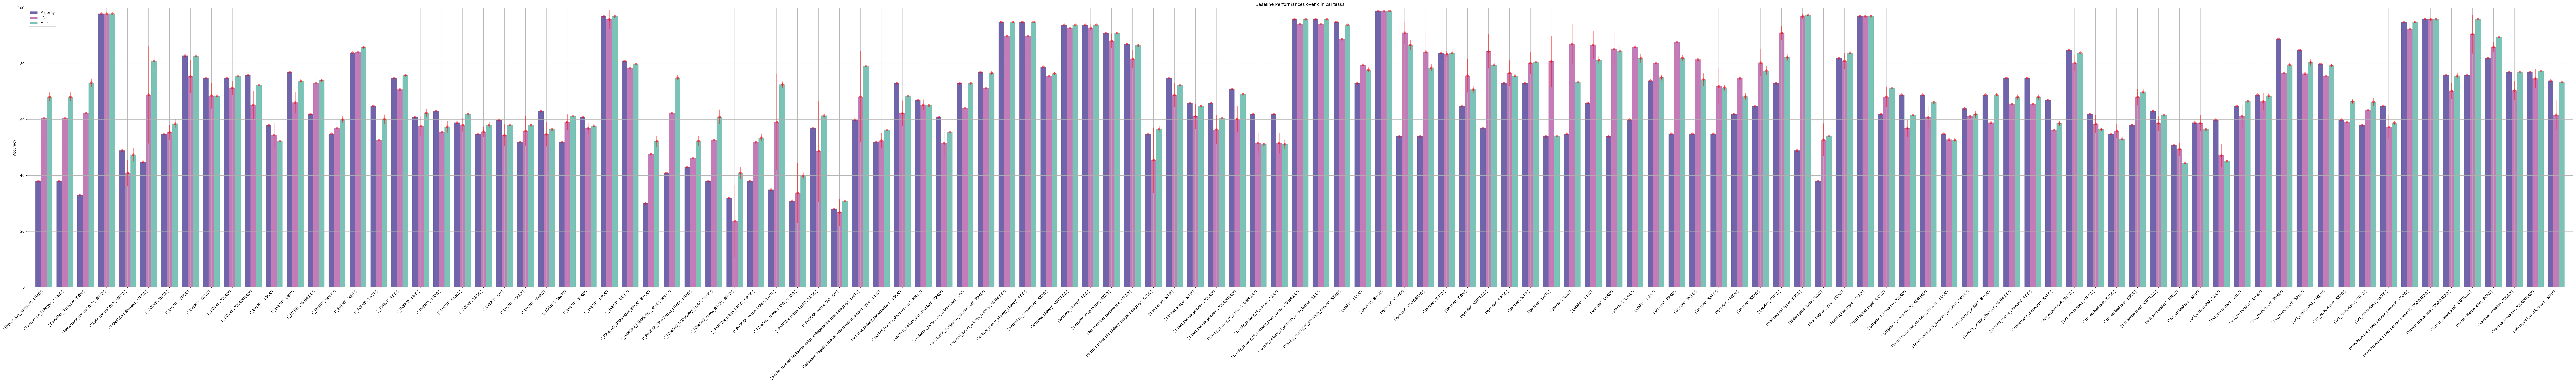

In [98]:
all_visualization(maj_means, lr_means, mlp_means, maj_stds, lr_stds, mlp_stds, MLP_res.keys())

In [106]:
mean_mean = []
mean_std = []

mean_mean.append(np.mean(maj_means))
mean_mean.append(np.mean(lr_means))
mean_mean.append(np.mean(mlp_means))
valid_tasks = list(MLP_res.keys())
CLT_ratio = np.sqrt(len(valid_tasks))
mean_std.append(np.std(maj_means)/CLT_ratio)
mean_std.append(np.std(lr_means)/CLT_ratio)
mean_std.append(np.std(mlp_means)/CLT_ratio)

print(mean_mean)
print(mean_std)

[66.18181818181819, 68.78512396694214, 71.19090909090909]
[1.5345218110918522, 1.4471688318614395, 1.329525788574559]


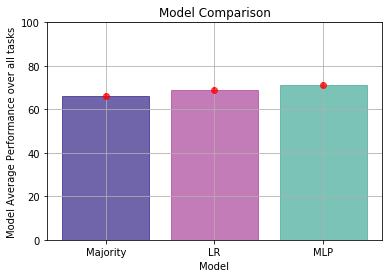

In [107]:
barlist=plt.bar([1,2,3], mean_mean, alpha=0.7)
barlist[0].set_color('#332288')
barlist[1].set_color('#AA4499')
barlist[2].set_color('#44AA99')
plt.xticks([1, 2, 3], ['Majority','LR','MLP'])
plt.title("Model Comparison")
plt.ylabel('Model Average Performance over all tasks')
plt.xlabel('Model')
plt.ylim(0,100)
plt.errorbar([1,2,3], mean_mean, mean_std, linestyle='None', marker='o', color='r', alpha=0.7)
plt.grid()
plt.show()